In [46]:
import pandas as pd # dataframe manipulation
import numpy as np # linear algebra

# data visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import shap

# sklearn 
from sklearn.cluster import KMeans
from sklearn.preprocessing import PowerTransformer, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, silhouette_samples, accuracy_score, classification_report

from pyod.models.ecod import ECOD
from yellowbrick.cluster import KElbowVisualizer

import lightgbm as lgb
import prince

In [47]:
def get_pca_2d(df, predict):
    pca_2d_object = prince.PCA(
    n_components=2,
    n_iter=3,
    rescale_with_mean=True,
    rescale_with_std=True,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42
    )

    pca_2d_object.fit(df)

    df_pca_2d = pca_2d_object.transform(df)
    df_pca_2d.columns = ["comp1", "comp2"]
    df_pca_2d["cluster"] = predict

    return pca_2d_object, df_pca_2d



def get_pca_3d(df, predict):
    pca_3d_object = prince.PCA(
        n_components=3,
        n_iter=3,
        rescale_with_mean=True,
        rescale_with_std=True,
        copy=True,
        check_input=True,
        engine='sklearn',
        random_state=42
    )

    pca_3d_object.fit(df)

    df_pca_3d = pca_3d_object.transform(df)
    df_pca_3d.columns = ["comp1", "comp2", "comp3"]
    df_pca_3d["cluster"] = predict

    return pca_3d_object, df_pca_3d



def plot_pca_3d(df, title = "PCA Space", opacity=0.8, width_line = 0.1):

    df = df.astype({"cluster": "object"})
    df = df.sort_values("cluster")

    fig = px.scatter_3d(df, 
                        x='comp1', 
                        y='comp2', 
                        z='comp3',
                        color='cluster',
                        template="plotly",
                        
                        # symbol = "cluster",
                        
                        color_discrete_sequence=px.colors.qualitative.Vivid,
                        title=title).update_traces(
                            # mode = 'markers',
                            marker={
                                "size": 4,
                                "opacity": opacity,
                                # "symbol" : "diamond",
                                "line": {
                                    "width": width_line,
                                    "color": "black",
                                }
                            }
                        ).update_layout(
                                width = 1000, 
                                height = 800, 
                                autosize = False, 
                                showlegend = True,
                                legend=dict(title_font_family="Times New Roman",
                                            font=dict(size= 20)),
                                scene = dict(xaxis=dict(title = 'comp1', titlefont_color = 'black'),
                                            yaxis=dict(title = 'comp2', titlefont_color = 'black'),
                                            zaxis=dict(title = 'comp3', titlefont_color = 'black')),
                                font = dict(family = "Gilroy", color  = 'black', size = 15))
                      
    
    fig.show()


def plot_pca_2d(df, title = "PCA Space", opacity=0.8, width_line = 0.1):

    df = df.astype({"cluster": "object"})
    df = df.sort_values("cluster")

    fig = px.scatter(df, 
                        x='comp1', 
                        y='comp2', 
                        color='cluster',
                        template="plotly",
                        # symbol = "cluster",
                        
                        color_discrete_sequence=px.colors.qualitative.Vivid,
                        title=title).update_traces(
                            # mode = 'markers',
                            marker={
                                "size": 8,
                                "opacity": opacity,
                                # "symbol" : "diamond",
                                "line": {
                                    "width": width_line,
                                    "color": "black",
                                }
                            }
                        ).update_layout(
                                width = 800, 
                                height = 700, 
                                autosize = False, 
                                showlegend = True,
                                legend=dict(title_font_family="Times New Roman",
                                            font=dict(size= 20)),
                                scene = dict(xaxis=dict(title = 'comp1', titlefont_color = 'black'),
                                            yaxis=dict(title = 'comp2', titlefont_color = 'black'),
                                            ),
                                font = dict(family = "Gilroy", color  = 'black', size = 15))
                        
        
    fig.show()


In [48]:
embedding_df = pd.read_csv('datasets/embeddings.csv')
rfm_df = pd.read_csv('datasets/rfm.csv')

In [49]:
embedding_df

0         1         2         3  \
0      00012a2ce6f8dcda20d059ce98491703 -0.039499  0.034394 -0.000282   
1      0001fd6190edaaf884bcaf3d49edf079 -0.026753  0.024523  0.008738   
2      0004164d20a9e969af783496f3408652 -0.026753  0.024523  0.008738   
3      00050bf6e01e69d5c0fd612f1bcfb69c -0.039499  0.034394 -0.000282   
4      00066ccbe787a588c52bd5ff404590e3 -0.018273  0.026520  0.009547   
...                                 ...       ...       ...       ...   
40278  fff415b4c72e09483a25c15108c65d31 -0.018273  0.026520  0.009547   
40279  fff5169e583fd07fac9fec88962f189d -0.023381  0.042027  0.005950   
40280  fff89c8ed4fcf69a823c1d149e429a0b -0.018273  0.026520  0.009547   
40281  fffcb937e9dd47a13f05ecb8290f4d3e -0.018273  0.026520  0.009547   
40282  ffff42319e9b2d713724ae527742af25 -0.023381  0.042027  0.005950   

              4         5         6         7         8         9  ...  \
0     -0.005606 -0.004398 -0.060583 -0.010778  0.041776  0.007883  ...   
1     -0.010952 -0.022316 -0.083617 -0.027215  0.038483  0.014858  ...   
2     -0.010952 -0.022316 -0.083617 -0.027215  0.038483  0.014858  ...   
3     -0.005606 -0.004398 -0.060583 -0.010778  0.041776  0.007883  ...   
4     -0.012819 -0.027588 -0.081065 -0.017282  0.034412  0.015713  ...   
...         ...       ...       ...       ...       ...       ...  ...   
40278 -0.012819 -0.027588 -0.081065 -0.017282  0.034412  0.015713  ...   
40279 -0.016656 -0.020946 -0.078030 -0.008602  0.033289  0.011274  ...   
40280 -0.012819 -0.027588 -0.081065 -0.017282  0.034412  0.015713  ...   
40281 -0.012819 -0.027588 -0.081065 -0.017282  0.034412  0.015713  ...   
40282 -0.016656 -0.020946 -0.078030 -0.008602  0.033289  0.011274  ...   

           1015      1016      1017      1018      1019      1020      1021  \
0     -0.046165 -0.024812  0.041468  0.021998  0.046361 -0.038339 -0.050337   
1     -0.046931 -0.003706  0.026630  0.013980  0.044408 -0.007335 -0.056692   
2     -0.046931 -0.003706  0.026630  0.013980  0.044408 -0.007335 -0.056692   
3     -0.046165 -0.024812  0.041468  0.021998  0.046361 -0.038339 -0.050337   
4     -0.036573 -0.006290  0.025652  0.004896  0.045379 -0.018905 -0.048207   
...         ...       ...       ...       ...       ...       ...       ...   
40278 -0.036573 -0.006290  0.025652  0.004896  0.045379 -0.018905 -0.048207   
40279 -0.039259 -0.007511  0.022079  0.005606  0.048311 -0.034339 -0.049960   
40280 -0.036573 -0.006290  0.025652  0.004896  0.045379 -0.018905 -0.048207   
40281 -0.036573 -0.006290  0.025652  0.004896  0.045379 -0.018905 -0.048207   
40282 -0.039259 -0.007511  0.022079  0.005606  0.048311 -0.034339 -0.049960   

           1022      1023      1024  
0      0.006869 -0.036489  0.010087  
1     -0.004921 -0.018381  0.009832  
2     -0.004921 -0.018381  0.009832  
3      0.006869 -0.036489  0.010087  
4     -0.006461 -0.023770  0.012949  
...         ...       ...       ...  
40278 -0.006461 -0.023770  0.012949  
40279 -0.008658 -0.014972  0.011896  
40280 -0.006461 -0.023770  0.012949  
40281 -0.006461 -0.023770  0.012949  
40282 -0.008658 -0.014972  0.011896  

[40283 rows x 1025 columns]

In [50]:
rfm_df

customer_id  recency  frequency  monetary_value  \
0      00012a2ce6f8dcda20d059ce98491703      293          1          114.74   
1      0001fd6190edaaf884bcaf3d49edf079      552          1          195.42   
2      0004164d20a9e969af783496f3408652      510          1           71.80   
3      00050bf6e01e69d5c0fd612f1bcfb69c      351          1           85.23   
4      00066ccbe787a588c52bd5ff404590e3      209          1          270.00   
...                                 ...      ...        ...             ...   
40278  fff415b4c72e09483a25c15108c65d31      283          1           84.57   
40279  fff5169e583fd07fac9fec88962f189d      115          1          152.77   
40280  fff89c8ed4fcf69a823c1d149e429a0b      261          1           44.10   
40281  fffcb937e9dd47a13f05ecb8290f4d3e      171          1           91.91   
40282  ffff42319e9b2d713724ae527742af25       82          1          214.13   

       avg_review_score                                            reviews  \
0                   1.0                             Everything as expected   
1                   5.0                                          Very good   
2                   1.0                   Product lacks clear information.   
3                   5.0                                      great product   
4                   1.0  Missing 3 chandeliers from my purchase, only o...   
...                 ...                                                ...   
40278               5.0  Product delivered ahead of time and everything...   
40279               1.0  I change my opinion as soon as I receive the p...   
40280               3.0  The doorknob covers came wrong, the NF contain...   
40281               5.0  the product was delivered before the deadline,...   
40282               5.0        A good quality product and on time delivery   

       RecencyScore  FrequencyScore  MonetaryScore RecencyScoreText  \
0               3.0             1.0            1.0   no so recently   
1               2.0             1.0            1.0    some time ago   
2               2.0             1.0            1.0    some time ago   
3               3.0             1.0            1.0   no so recently   
4               4.0             1.0            1.0         recently   
...             ...             ...            ...              ...   
40278           4.0             1.0            1.0         recently   
40279           5.0             1.0            1.0    very recently   
40280           4.0             1.0            1.0         recently   
40281           4.0             1.0            1.0         recently   
40282           5.0             1.0            1.0    very recently   

      FrequencyScoreText         MonetaryScoreText  
0       extremely rarely  only a very little money  
1       extremely rarely  only a very little money  
2       extremely rarely  only a very little money  
3       extremely rarely  only a very little money  
4       extremely rarely  only a very little money  
...                  ...                       ...  
40278   extremely rarely  only a very little money  
40279   extremely rarely  only a very little money  
40280   extremely rarely  only a very little money  
40281   extremely rarely  only a very little money  
40282   extremely rarely  only a very little money  

[40283 rows x 12 columns]

Outliers

In [51]:
from pyod.models.ecod import ECOD
# https://github.com/yzhao062/pyod

# Unsupervised Outlier Detection Using Empirical Cumulative Distribution Functions (ECOD)
clf = ECOD()
clf.fit(embedding_df.iloc[:, 1:])

out = clf.predict(embedding_df.iloc[:, 1:]) 
embedding_df["outliers"] = out
rfm_df["outliers"] = out

df_embedding_no_out = embedding_df[embedding_df["outliers"] == 0]
df_embedding_no_out = df_embedding_no_out.drop(["outliers"], axis = 1)

df_embedding_with_out = embedding_df.copy()
df_embedding_with_out = df_embedding_with_out.drop(["outliers"], axis = 1)

rfm_no_out = rfm_df[rfm_df["outliers"] == 0]
rfm_no_out = rfm_no_out.drop(["outliers"], axis = 1)
rfm_df = rfm_no_out

In [52]:
rfm_df

customer_id  recency  frequency  monetary_value  \
0      00012a2ce6f8dcda20d059ce98491703      293          1          114.74   
1      0001fd6190edaaf884bcaf3d49edf079      552          1          195.42   
2      0004164d20a9e969af783496f3408652      510          1           71.80   
3      00050bf6e01e69d5c0fd612f1bcfb69c      351          1           85.23   
4      00066ccbe787a588c52bd5ff404590e3      209          1          270.00   
...                                 ...      ...        ...             ...   
40278  fff415b4c72e09483a25c15108c65d31      283          1           84.57   
40279  fff5169e583fd07fac9fec88962f189d      115          1          152.77   
40280  fff89c8ed4fcf69a823c1d149e429a0b      261          1           44.10   
40281  fffcb937e9dd47a13f05ecb8290f4d3e      171          1           91.91   
40282  ffff42319e9b2d713724ae527742af25       82          1          214.13   

       avg_review_score                                            reviews  \
0                   1.0                             Everything as expected   
1                   5.0                                          Very good   
2                   1.0                   Product lacks clear information.   
3                   5.0                                      great product   
4                   1.0  Missing 3 chandeliers from my purchase, only o...   
...                 ...                                                ...   
40278               5.0  Product delivered ahead of time and everything...   
40279               1.0  I change my opinion as soon as I receive the p...   
40280               3.0  The doorknob covers came wrong, the NF contain...   
40281               5.0  the product was delivered before the deadline,...   
40282               5.0        A good quality product and on time delivery   

       RecencyScore  FrequencyScore  MonetaryScore RecencyScoreText  \
0               3.0             1.0            1.0   no so recently   
1               2.0             1.0            1.0    some time ago   
2               2.0             1.0            1.0    some time ago   
3               3.0             1.0            1.0   no so recently   
4               4.0             1.0            1.0         recently   
...             ...             ...            ...              ...   
40278           4.0             1.0            1.0         recently   
40279           5.0             1.0            1.0    very recently   
40280           4.0             1.0            1.0         recently   
40281           4.0             1.0            1.0         recently   
40282           5.0             1.0            1.0    very recently   

      FrequencyScoreText         MonetaryScoreText  
0       extremely rarely  only a very little money  
1       extremely rarely  only a very little money  
2       extremely rarely  only a very little money  
3       extremely rarely  only a very little money  
4       extremely rarely  only a very little money  
...                  ...                       ...  
40278   extremely rarely  only a very little money  
40279   extremely rarely  only a very little money  
40280   extremely rarely  only a very little money  
40281   extremely rarely  only a very little money  
40282   extremely rarely  only a very little money  

[39698 rows x 12 columns]

In [53]:
df_embedding_no_out.shape

(39698, 1025)

In [54]:
df_embedding_with_out.shape

(40283, 1025)

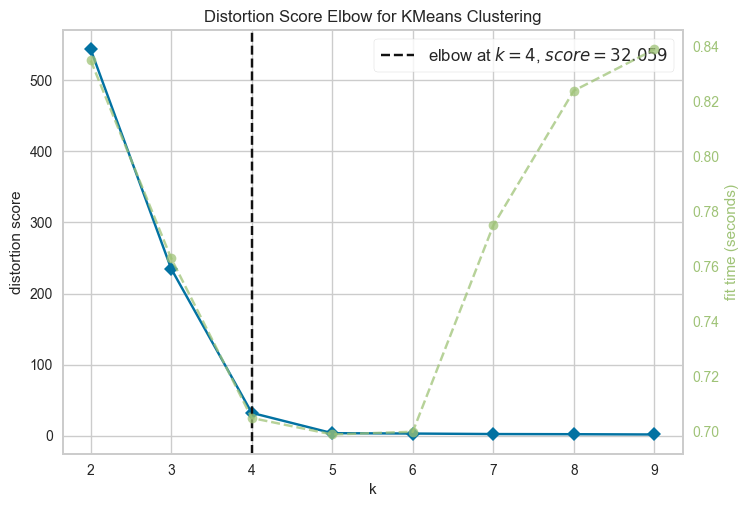

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [55]:
# Instantiate the clustering model and visualizer
km = KMeans(init="k-means++", random_state=0, n_init="auto")
visualizer = KElbowVisualizer(km, k=(2,10), locate_elbow=True)

visualizer.fit(df_embedding_with_out.iloc[:, 1:])        # Fit the data to the visualizer
visualizer.show()   

In [56]:
# def make_Silhouette_plot(X, n_clusters):
#     plt.xlim([-0.1, 1])
#     plt.ylim([0, len(X) + (n_clusters + 1) * 10])
#     clusterer = KMeans(n_clusters=n_clusters, max_iter = 1000, n_init = 10, init = 'k-means++', random_state=10)
#     cluster_labels = clusterer.fit_predict(X)
#     silhouette_avg = silhouette_score(X, cluster_labels)
#     print(
#         "For n_clusters =", n_clusters,
#         "The average silhouette_score is :", silhouette_avg,
#     )
# # Compute the silhouette scores for each sample
#     sample_silhouette_values = silhouette_samples(X, cluster_labels)
#     y_lower = 10
#     for i in range(n_clusters):
#         ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
#         ith_cluster_silhouette_values.sort()
#         size_cluster_i = ith_cluster_silhouette_values.shape[0]
#         y_upper = y_lower + size_cluster_i
#         color = cm.nipy_spectral(float(i) / n_clusters)
#         plt.fill_betweenx(
#             np.arange(y_lower, y_upper),
#             0,
#             ith_cluster_silhouette_values,
#             facecolor=color,
#             edgecolor=color,
#             alpha=0.7,
#         )
#         plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
#         y_lower = y_upper + 10
#         plt.title(f"The Silhouette Plot for n_cluster = {n_clusters}", fontsize=26)
#         plt.xlabel("The silhouette coefficient values", fontsize=24)
#         plt.ylabel("Cluster label", fontsize=24)
#         plt.axvline(x=silhouette_avg, color="red", linestyle="--")
#         plt.yticks([])  
#         plt.xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
# range_n_clusters = list(range(2,10))
# for n_clusters in range_n_clusters:
#     print(f"N cluster: {n_clusters}")
#     make_Silhouette_plot(df_embedding_no_out, n_clusters)   
#     plt.savefig('Silhouette_plot_{}.png'.format(n_clusters))
#     plt.close()

In [57]:
n_clusters = 4

In [58]:
clusters = KMeans(n_clusters=n_clusters, init = "k-means++").fit(df_embedding_no_out.iloc[:, 1:])
print(clusters.inertia_)
clusters_predict = clusters.predict(df_embedding_no_out.iloc[:, 1:])

C:\Users\Shamika Tissera\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



4.0526721825602537e-25


In [59]:
clusters_predict

array([1, 3, 3, ..., 0, 0, 2])

In [60]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score

"""
The Davies Bouldin index is defined as the average similarity measure of each cluster with its most similar cluster, where similarity is the ratio of within-cluster distances to between-cluster distances.
The minimum value of the DB Index is 0, whereas a smaller value (closer to 0) represents a better model that produces better clusters.
"""
print(f"Davies bouldin Score: {davies_bouldin_score(df_embedding_no_out.iloc[:, 1:],clusters_predict)}")

"""
Calinski Harabaz Index -> Variance Ratio Criterion.
Calinski Harabaz Index is defined as the ratio of the sum of between-cluster dispersion and of within-cluster dispersion.
The higher the index the more separable the clusters.
"""
print(f"Calinski Score: {calinski_harabasz_score(df_embedding_no_out.iloc[:, 1:],clusters_predict)}")


"""
The silhouette score is a metric used to calculate the goodness of fit of a clustering algorithm, but can also be used as a method for determining an optimal value of k (see here for more).
Its value ranges from -1 to 1.
A value of 0 indicates clusters are overlapping and either the data or the value of k is incorrect.
1 is the ideal value and indicates that clusters are very dense and nicely separated.
"""
print(f"Silhouette Score: {silhouette_score(df_embedding_no_out.iloc[:, 1:],clusters_predict)}")

Davies bouldin Score: 0.0
Calinski Score: 1.8470511543999364e+32
Silhouette Score: 1.0


In [61]:
df_embedding_no_out

0         1         2         3  \
0      00012a2ce6f8dcda20d059ce98491703 -0.039499  0.034394 -0.000282   
1      0001fd6190edaaf884bcaf3d49edf079 -0.026753  0.024523  0.008738   
2      0004164d20a9e969af783496f3408652 -0.026753  0.024523  0.008738   
3      00050bf6e01e69d5c0fd612f1bcfb69c -0.039499  0.034394 -0.000282   
4      00066ccbe787a588c52bd5ff404590e3 -0.018273  0.026520  0.009547   
...                                 ...       ...       ...       ...   
40278  fff415b4c72e09483a25c15108c65d31 -0.018273  0.026520  0.009547   
40279  fff5169e583fd07fac9fec88962f189d -0.023381  0.042027  0.005950   
40280  fff89c8ed4fcf69a823c1d149e429a0b -0.018273  0.026520  0.009547   
40281  fffcb937e9dd47a13f05ecb8290f4d3e -0.018273  0.026520  0.009547   
40282  ffff42319e9b2d713724ae527742af25 -0.023381  0.042027  0.005950   

              4         5         6         7         8         9  ...  \
0     -0.005606 -0.004398 -0.060583 -0.010778  0.041776  0.007883  ...   
1     -0.010952 -0.022316 -0.083617 -0.027215  0.038483  0.014858  ...   
2     -0.010952 -0.022316 -0.083617 -0.027215  0.038483  0.014858  ...   
3     -0.005606 -0.004398 -0.060583 -0.010778  0.041776  0.007883  ...   
4     -0.012819 -0.027588 -0.081065 -0.017282  0.034412  0.015713  ...   
...         ...       ...       ...       ...       ...       ...  ...   
40278 -0.012819 -0.027588 -0.081065 -0.017282  0.034412  0.015713  ...   
40279 -0.016656 -0.020946 -0.078030 -0.008602  0.033289  0.011274  ...   
40280 -0.012819 -0.027588 -0.081065 -0.017282  0.034412  0.015713  ...   
40281 -0.012819 -0.027588 -0.081065 -0.017282  0.034412  0.015713  ...   
40282 -0.016656 -0.020946 -0.078030 -0.008602  0.033289  0.011274  ...   

           1015      1016      1017      1018      1019      1020      1021  \
0     -0.046165 -0.024812  0.041468  0.021998  0.046361 -0.038339 -0.050337   
1     -0.046931 -0.003706  0.026630  0.013980  0.044408 -0.007335 -0.056692   
2     -0.046931 -0.003706  0.026630  0.013980  0.044408 -0.007335 -0.056692   
3     -0.046165 -0.024812  0.041468  0.021998  0.046361 -0.038339 -0.050337   
4     -0.036573 -0.006290  0.025652  0.004896  0.045379 -0.018905 -0.048207   
...         ...       ...       ...       ...       ...       ...       ...   
40278 -0.036573 -0.006290  0.025652  0.004896  0.045379 -0.018905 -0.048207   
40279 -0.039259 -0.007511  0.022079  0.005606  0.048311 -0.034339 -0.049960   
40280 -0.036573 -0.006290  0.025652  0.004896  0.045379 -0.018905 -0.048207   
40281 -0.036573 -0.006290  0.025652  0.004896  0.045379 -0.018905 -0.048207   
40282 -0.039259 -0.007511  0.022079  0.005606  0.048311 -0.034339 -0.049960   

           1022      1023      1024  
0      0.006869 -0.036489  0.010087  
1     -0.004921 -0.018381  0.009832  
2     -0.004921 -0.018381  0.009832  
3      0.006869 -0.036489  0.010087  
4     -0.006461 -0.023770  0.012949  
...         ...       ...       ...  
40278 -0.006461 -0.023770  0.012949  
40279 -0.008658 -0.014972  0.011896  
40280 -0.006461 -0.023770  0.012949  
40281 -0.006461 -0.023770  0.012949  
40282 -0.008658 -0.014972  0.011896  

[39698 rows x 1025 columns]

In [62]:
# df_embedding_no_out = df_embedding_no_out.iloc[:, 1:]


In [63]:
print(rfm_df.shape)
print(df_embedding_no_out.shape)

(39698, 12)
(39698, 1025)


In [64]:
# # compare the two dataframes customer ids and remove the ones that are not in the df_embedding_no_out dataframe
# print(rfm_df.shape)
# print(df_embedding_no_out.shape)

# rfm_df = rfm_df[rfm_df["customer_id"].isin(df_embedding_no_out['0'])]
# print(rfm_df.shape)



In [65]:
rfm_df

customer_id  recency  frequency  monetary_value  \
0      00012a2ce6f8dcda20d059ce98491703      293          1          114.74   
1      0001fd6190edaaf884bcaf3d49edf079      552          1          195.42   
2      0004164d20a9e969af783496f3408652      510          1           71.80   
3      00050bf6e01e69d5c0fd612f1bcfb69c      351          1           85.23   
4      00066ccbe787a588c52bd5ff404590e3      209          1          270.00   
...                                 ...      ...        ...             ...   
40278  fff415b4c72e09483a25c15108c65d31      283          1           84.57   
40279  fff5169e583fd07fac9fec88962f189d      115          1          152.77   
40280  fff89c8ed4fcf69a823c1d149e429a0b      261          1           44.10   
40281  fffcb937e9dd47a13f05ecb8290f4d3e      171          1           91.91   
40282  ffff42319e9b2d713724ae527742af25       82          1          214.13   

       avg_review_score                                            reviews  \
0                   1.0                             Everything as expected   
1                   5.0                                          Very good   
2                   1.0                   Product lacks clear information.   
3                   5.0                                      great product   
4                   1.0  Missing 3 chandeliers from my purchase, only o...   
...                 ...                                                ...   
40278               5.0  Product delivered ahead of time and everything...   
40279               1.0  I change my opinion as soon as I receive the p...   
40280               3.0  The doorknob covers came wrong, the NF contain...   
40281               5.0  the product was delivered before the deadline,...   
40282               5.0        A good quality product and on time delivery   

       RecencyScore  FrequencyScore  MonetaryScore RecencyScoreText  \
0               3.0             1.0            1.0   no so recently   
1               2.0             1.0            1.0    some time ago   
2               2.0             1.0            1.0    some time ago   
3               3.0             1.0            1.0   no so recently   
4               4.0             1.0            1.0         recently   
...             ...             ...            ...              ...   
40278           4.0             1.0            1.0         recently   
40279           5.0             1.0            1.0    very recently   
40280           4.0             1.0            1.0         recently   
40281           4.0             1.0            1.0         recently   
40282           5.0             1.0            1.0    very recently   

      FrequencyScoreText         MonetaryScoreText  
0       extremely rarely  only a very little money  
1       extremely rarely  only a very little money  
2       extremely rarely  only a very little money  
3       extremely rarely  only a very little money  
4       extremely rarely  only a very little money  
...                  ...                       ...  
40278   extremely rarely  only a very little money  
40279   extremely rarely  only a very little money  
40280   extremely rarely  only a very little money  
40281   extremely rarely  only a very little money  
40282   extremely rarely  only a very little money  

[39698 rows x 12 columns]

In [66]:
rfm_df["cluster"] = clusters_predict
rfm_df

customer_id  recency  frequency  monetary_value  \
0      00012a2ce6f8dcda20d059ce98491703      293          1          114.74   
1      0001fd6190edaaf884bcaf3d49edf079      552          1          195.42   
2      0004164d20a9e969af783496f3408652      510          1           71.80   
3      00050bf6e01e69d5c0fd612f1bcfb69c      351          1           85.23   
4      00066ccbe787a588c52bd5ff404590e3      209          1          270.00   
...                                 ...      ...        ...             ...   
40278  fff415b4c72e09483a25c15108c65d31      283          1           84.57   
40279  fff5169e583fd07fac9fec88962f189d      115          1          152.77   
40280  fff89c8ed4fcf69a823c1d149e429a0b      261          1           44.10   
40281  fffcb937e9dd47a13f05ecb8290f4d3e      171          1           91.91   
40282  ffff42319e9b2d713724ae527742af25       82          1          214.13   

       avg_review_score                                            reviews  \
0                   1.0                             Everything as expected   
1                   5.0                                          Very good   
2                   1.0                   Product lacks clear information.   
3                   5.0                                      great product   
4                   1.0  Missing 3 chandeliers from my purchase, only o...   
...                 ...                                                ...   
40278               5.0  Product delivered ahead of time and everything...   
40279               1.0  I change my opinion as soon as I receive the p...   
40280               3.0  The doorknob covers came wrong, the NF contain...   
40281               5.0  the product was delivered before the deadline,...   
40282               5.0        A good quality product and on time delivery   

       RecencyScore  FrequencyScore  MonetaryScore RecencyScoreText  \
0               3.0             1.0            1.0   no so recently   
1               2.0             1.0            1.0    some time ago   
2               2.0             1.0            1.0    some time ago   
3               3.0             1.0            1.0   no so recently   
4               4.0             1.0            1.0         recently   
...             ...             ...            ...              ...   
40278           4.0             1.0            1.0         recently   
40279           5.0             1.0            1.0    very recently   
40280           4.0             1.0            1.0         recently   
40281           4.0             1.0            1.0         recently   
40282           5.0             1.0            1.0    very recently   

      FrequencyScoreText         MonetaryScoreText  cluster  
0       extremely rarely  only a very little money        1  
1       extremely rarely  only a very little money        3  
2       extremely rarely  only a very little money        3  
3       extremely rarely  only a very little money        1  
4       extremely rarely  only a very little money        0  
...                  ...                       ...      ...  
40278   extremely rarely  only a very little money        0  
40279   extremely rarely  only a very little money        2  
40280   extremely rarely  only a very little money        0  
40281   extremely rarely  only a very little money        0  
40282   extremely rarely  only a very little money        2  

[39698 rows x 13 columns]

In [67]:
df_embedding_no_out

0         1         2         3  \
0      00012a2ce6f8dcda20d059ce98491703 -0.039499  0.034394 -0.000282   
1      0001fd6190edaaf884bcaf3d49edf079 -0.026753  0.024523  0.008738   
2      0004164d20a9e969af783496f3408652 -0.026753  0.024523  0.008738   
3      00050bf6e01e69d5c0fd612f1bcfb69c -0.039499  0.034394 -0.000282   
4      00066ccbe787a588c52bd5ff404590e3 -0.018273  0.026520  0.009547   
...                                 ...       ...       ...       ...   
40278  fff415b4c72e09483a25c15108c65d31 -0.018273  0.026520  0.009547   
40279  fff5169e583fd07fac9fec88962f189d -0.023381  0.042027  0.005950   
40280  fff89c8ed4fcf69a823c1d149e429a0b -0.018273  0.026520  0.009547   
40281  fffcb937e9dd47a13f05ecb8290f4d3e -0.018273  0.026520  0.009547   
40282  ffff42319e9b2d713724ae527742af25 -0.023381  0.042027  0.005950   

              4         5         6         7         8         9  ...  \
0     -0.005606 -0.004398 -0.060583 -0.010778  0.041776  0.007883  ...   
1     -0.010952 -0.022316 -0.083617 -0.027215  0.038483  0.014858  ...   
2     -0.010952 -0.022316 -0.083617 -0.027215  0.038483  0.014858  ...   
3     -0.005606 -0.004398 -0.060583 -0.010778  0.041776  0.007883  ...   
4     -0.012819 -0.027588 -0.081065 -0.017282  0.034412  0.015713  ...   
...         ...       ...       ...       ...       ...       ...  ...   
40278 -0.012819 -0.027588 -0.081065 -0.017282  0.034412  0.015713  ...   
40279 -0.016656 -0.020946 -0.078030 -0.008602  0.033289  0.011274  ...   
40280 -0.012819 -0.027588 -0.081065 -0.017282  0.034412  0.015713  ...   
40281 -0.012819 -0.027588 -0.081065 -0.017282  0.034412  0.015713  ...   
40282 -0.016656 -0.020946 -0.078030 -0.008602  0.033289  0.011274  ...   

           1015      1016      1017      1018      1019      1020      1021  \
0     -0.046165 -0.024812  0.041468  0.021998  0.046361 -0.038339 -0.050337   
1     -0.046931 -0.003706  0.026630  0.013980  0.044408 -0.007335 -0.056692   
2     -0.046931 -0.003706  0.026630  0.013980  0.044408 -0.007335 -0.056692   
3     -0.046165 -0.024812  0.041468  0.021998  0.046361 -0.038339 -0.050337   
4     -0.036573 -0.006290  0.025652  0.004896  0.045379 -0.018905 -0.048207   
...         ...       ...       ...       ...       ...       ...       ...   
40278 -0.036573 -0.006290  0.025652  0.004896  0.045379 -0.018905 -0.048207   
40279 -0.039259 -0.007511  0.022079  0.005606  0.048311 -0.034339 -0.049960   
40280 -0.036573 -0.006290  0.025652  0.004896  0.045379 -0.018905 -0.048207   
40281 -0.036573 -0.006290  0.025652  0.004896  0.045379 -0.018905 -0.048207   
40282 -0.039259 -0.007511  0.022079  0.005606  0.048311 -0.034339 -0.049960   

           1022      1023      1024  
0      0.006869 -0.036489  0.010087  
1     -0.004921 -0.018381  0.009832  
2     -0.004921 -0.018381  0.009832  
3      0.006869 -0.036489  0.010087  
4     -0.006461 -0.023770  0.012949  
...         ...       ...       ...  
40278 -0.006461 -0.023770  0.012949  
40279 -0.008658 -0.014972  0.011896  
40280 -0.006461 -0.023770  0.012949  
40281 -0.006461 -0.023770  0.012949  
40282 -0.008658 -0.014972  0.011896  

[39698 rows x 1025 columns]

In [68]:
# rfm_df.drop(["outliers"], axis = 1, inplace = True)

In [69]:
# plot the clusters in 3d
pca_3d_object, df_pca_3d = get_pca_3d(df_embedding_no_out.iloc[:, 1:], clusters_predict)
plot_pca_3d(df_pca_3d, title = "PCA Space with 3 Clusters", opacity=0.8, width_line = 0.1)
print("The variability is :", pca_3d_object.eigenvalues_summary)

The variability is :           eigenvalue % of variance % of variance (cumulative)
component                                                    
0            544.681        53.19%                     53.19%
1            270.758        26.44%                     79.63%
2            208.562        20.37%                    100.00%


In [70]:
# calculate silhouette score
silhouette_score(df_embedding_no_out.iloc[:, 1:], clusters_predict)

1.0

In [71]:
rfm_df.describe()

recency    frequency  monetary_value  avg_review_score  \
count  39698.000000  39698.00000    39698.000000      39698.000000   
mean     245.852738      1.04174      173.978291          3.699909   
std      149.250352      0.26185      217.782249          1.600391   
min        1.000000      1.00000       10.070000          1.000000   
25%      125.000000      1.00000       65.715000          2.000000   
50%      228.000000      1.00000      113.440000          5.000000   
75%      355.000000      1.00000      192.027500          5.000000   
max      583.000000      6.00000     2734.660000          5.000000   

       RecencyScore  FrequencyScore  MonetaryScore       cluster  
count  39698.000000         39698.0        39698.0  39698.000000  
mean       3.817925             1.0            1.0      1.217996  
std        1.010960             0.0            0.0      1.074726  
min        2.000000             1.0            1.0      0.000000  
25%        3.000000             1.0            1.0      0.000000  
50%        4.000000             1.0            1.0      1.000000  
75%        5.000000             1.0            1.0      2.000000  
max        5.000000             1.0            1.0      3.000000

In [72]:
# analyze the clusters' characteristics
copy = rfm_df.groupby('cluster').agg(
    {
        'recency': 'mean',
        'frequency': 'mean',
        'monetary_value': ['mean', 'count']
    }
).reset_index()

copy.columns = ['cluster', 'recency_mean', 'frequency_mean', 'monetary_value_mean', 'count']

copy['TotalRFM'] = copy['recency_mean'] + copy['frequency_mean'] + copy['monetary_value_mean']

copy.sort_values('TotalRFM', ascending=False)

copy

cluster  recency_mean  frequency_mean  monetary_value_mean  count  \
0        0    220.222836        1.038699           169.417231  14109   
1        1    362.317593        1.052549           176.109178   8259   
2        2     78.101034        1.032697           177.397915  11897   
3        3    502.703663        1.053009           175.095489   5433   

     TotalRFM  
0  390.678766  
1  539.479320  
2  256.531646  
3  678.852161

In [ ]:
rfm_df

customer_id  recency  frequency  monetary_value  avg_review_score reviews  \
0           NaN      NaN        NaN             NaN               NaN     NaN   
1           NaN      NaN        NaN             NaN               NaN     NaN   
2           NaN      NaN        NaN             NaN               NaN     NaN   
3           NaN      NaN        NaN             NaN               NaN     NaN   
4           NaN      NaN        NaN             NaN               NaN     NaN   
..          ...      ...        ...             ...               ...     ...   
895         NaN      NaN        NaN             NaN               NaN     NaN   
896         NaN      NaN        NaN             NaN               NaN     NaN   
897         NaN      NaN        NaN             NaN               NaN     NaN   
898         NaN      NaN        NaN             NaN               NaN     NaN   
899         NaN      NaN        NaN             NaN               NaN     NaN   

     cluster  
0          1  
1          2  
2          1  
3          0  
4          3  
..       ...  
895        1  
896        2  
897        0  
898        3  
899        3  

[900 rows x 7 columns]

In [33]:
# import plotly.express as px

# # plot the clusters for rfm_df
# fig = px.scatter_3d(rfm_df,
#                     x = "Recency",
#                     y = "Frequency",
#                     z = "MonetaryValue",
#                     template="plotly",
#                     color_discrete_sequence=px.colors.qualitative.Vivid,
#                     title = "Clusters for RFM",
#                     opacity=0.8,
#                     width = 1000, 
#                     height = 800, 
#                     )
# fig.update_layout(showlegend=True,
#                   scene = dict(xaxis=dict(title = 'Recency', titlefont_color = 'black'),
#                                yaxis=dict(title = 'Frequency', titlefont_color = 'black'),
#                                zaxis=dict(title = 'MonetaryValue', titlefont_color = 'black')),
#                   font = dict(family = "Gilroy", color  = 'black', size = 15),
#                   autosize = False, 
#                   legend=dict(title_font_family="Times New Roman",
#                               font=dict(size= 20)))
# fig.show()


In [34]:
# # calculate the silhouette score for the rfm_df
# silhouette_score(rfm_df.iloc[:, 1:-1], clusters_predict)

In [35]:
# pca_3d_object, df_pca_3d = get_pca_3d(rfm_df.iloc[:, 1:], clusters_predict)
# plot_pca_3d(df_pca_3d, title = "PCA Space", opacity=1, width_line = 0.1)
# # %pip install nbformat
# print("The variability is :", pca_3d_object.eigenvalues_summary)

In [114]:
# plot the clusters in 3d
df_pca_3d

comp1     comp2     comp3  cluster
0      1.480052 -1.151488 -0.471585        1
1     -0.423704 -0.289288  1.742467        3
2     -0.221283 -1.525756 -0.936199        0
3      0.268877 -0.380942 -1.105493        1
8      0.579288  1.087668  1.607004        3
...         ...       ...       ...      ...
40278  0.306603 -1.024924 -1.078315        0
40279  1.438107 -1.233980  1.180438        3
40280 -1.239765 -0.244441 -0.066563        0
40281  0.475139  0.537138 -1.108250        1
40282 -1.002942 -1.030413  1.275490        0

[36254 rows x 4 columns]

In [248]:
pca_2d_object, df_pca_2d = get_pca_2d(rfm_df.iloc[:, 1:], clusters_predict)
plot_pca_2d(df_pca_2d, title = "PCA Space", opacity=1, width_line = 0.2)


ValueError: could not convert string to float: 'Everything as expected'

In [249]:
sampling_data = df_embedding_no_out.sample(frac=0.5, replace=True, random_state=1)
sampling_clusters = pd.DataFrame(clusters_predict).sample(frac=0.5, replace=True, random_state=1)[0].values

df_tsne_3d = TSNE(
                  n_components=3, 
                  learning_rate=500, 
                  init='random', 
                  perplexity=200, 
                  n_iter = 5000).fit_transform(sampling_data.iloc[:, 1:])

df_tsne_3d = pd.DataFrame(df_tsne_3d, columns=["comp1", "comp2",'comp3'])
df_tsne_3d["cluster"] = sampling_clusters
plot_pca_3d(df_tsne_3d, title = "T-SNE Space", opacity=1, width_line = 0.1)

In [252]:
plot_pca_3d(df_tsne_3d, title = "T-SNE Space", opacity=0.1, width_line = 0.1)

In [ ]:
df_tsne_2d = TSNE(
                  n_components=2, 
                  learning_rate=500, 
                  init='random', 
                  perplexity=200, 
                  n_iter = 5000).fit_transform(sampling_data)

df_tsne_2d = pd.DataFrame(df_tsne_2d, columns=["comp1", "comp2"])
df_tsne_2d["cluster"] = sampling_clusters

plot_pca_2d(df_tsne_2d, title = "PCA Space", opacity=0.5, width_line = 0.5)


ValueError: could not convert string to float: 'df913529b303b9222440b3ea06e2cd1e'

In [ ]:
plot_pca_2d(df_tsne_2d, title = "PCA Space", opacity=1, width_line = 0.5)


In [ ]:
df_no_outliers = rfm_df[rfm_df["outliers"] == 0]
df_no_outliers = df_no_outliers.drop("outliers", axis = 1)

In [ ]:
import pandas as pd
import lightgbm as lgb
import shap

clf_km = lgb.LGBMClassifier(colsample_by_tree=0.8)

for col in ["Recency", "Frequency", "MonetaryValue"]:
    df_no_outliers[col] = df_no_outliers[col].astype('category')

clf_km.fit(X = df_no_outliers.iloc[:, 1:] , y = clusters_predict)

#SHAP values
explainer_km = shap.TreeExplainer(clf_km)
shap_values_km = explainer_km.shap_values(df_no_outliers)
shap.summary_plot(shap_values_km, df_no_outliers, plot_type="bar", plot_size=(15, 10))

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002118 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9662
[LightGBM] [Info] Number of data points in the train set: 88798, number of used features: 3
[LightGBM] [Info] Start training from score -0.137894
[LightGBM] [Info] Start training from score -2.566798
[LightGBM] [Info] Start training from score -2.955969


ValueError: pandas dtypes must be int, float or bool.
Fields with bad pandas dtypes: customer_id: object

In [ ]:
y_pred = clf_km.predict(df_no_outliers)
accuracy=accuracy_score(y_pred, clusters_predict)
print('Training-set accuracy score: {0:0.4f}'. format(accuracy))
print(classification_report(clusters_predict, y_pred))

In [ ]:
df_no_outliers["cluster"] = clusters_predict

df_group = df_no_outliers.groupby('cluster').agg(
    {
        'Recency': lambda x: x.value_counts().index[0],
        'Frequency': lambda x: x.value_counts().index[0],
        'Monetary Value': lambda x: x.value_counts().index[0]        
    }
).       sort_values("").reset_index()
df_group